# Inference and Validation

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/',
                                 download=True,
                                 train=True,
                                 transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=64,
                                          shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/',
                                 download=True,
                                 train=False,
                                 transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=64,
                                          shuffle=True)

In [2]:
# Create a model
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. There many options like accuracy, precision an recall, top-5 error rate an so on.

In [3]:
model = Classifier()

images, labels = next(iter(testloader))

# Get the class probabilities
ps = torch.exp(model(images))
# we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [4]:
top_p, top_class = ps.topk(1, dim=1)
# look at the most likely classes for the first
# 10 examples
print(top_class[:10,:])

tensor([[8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [5]:
#equals = top_class == labels
equals = top_class == labels.view(*top_class.shape)
print(equals.shape)
print(equals)

torch.Size([64, 1])
tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [Fa

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implement for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [6]:
equals.shape

torch.Size([64, 1])

In [7]:
equals

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False

Now we need to calculate the percentage of correct predictions.

But first we need to convert them to floats.

In [8]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 9.375%


In [9]:
accuracy

tensor(0.0938)

**Exercise**

Implement the validation loop below and print out the total accuracy after the loop.

In [10]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=0.003)
epochs = 30
steps = 0

train_losses, test_losses = [], []

for epoch in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        val_accuracy = 0
        # Implement the validation pass and
        # print out the validation accuracy
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(val_accuracy/len(testloader))
             )

Epoch: 1/30..  Training Loss: 0.515..  Test Loss: 0.465..  Test Accuracy: 0.831
Epoch: 2/30..  Training Loss: 0.391..  Test Loss: 0.414..  Test Accuracy: 0.855
Epoch: 3/30..  Training Loss: 0.353..  Test Loss: 0.386..  Test Accuracy: 0.859
Epoch: 4/30..  Training Loss: 0.329..  Test Loss: 0.379..  Test Accuracy: 0.866
Epoch: 5/30..  Training Loss: 0.314..  Test Loss: 0.383..  Test Accuracy: 0.866
Epoch: 6/30..  Training Loss: 0.300..  Test Loss: 0.358..  Test Accuracy: 0.876
Epoch: 7/30..  Training Loss: 0.293..  Test Loss: 0.369..  Test Accuracy: 0.867
Epoch: 8/30..  Training Loss: 0.284..  Test Loss: 0.369..  Test Accuracy: 0.873
Epoch: 9/30..  Training Loss: 0.275..  Test Loss: 0.349..  Test Accuracy: 0.881
Epoch: 10/30..  Training Loss: 0.265..  Test Loss: 0.364..  Test Accuracy: 0.876
Epoch: 11/30..  Training Loss: 0.258..  Test Loss: 0.364..  Test Accuracy: 0.877
Epoch: 12/30..  Training Loss: 0.257..  Test Loss: 0.349..  Test Accuracy: 0.881
Epoch: 13/30..  Training Loss: 0.247.

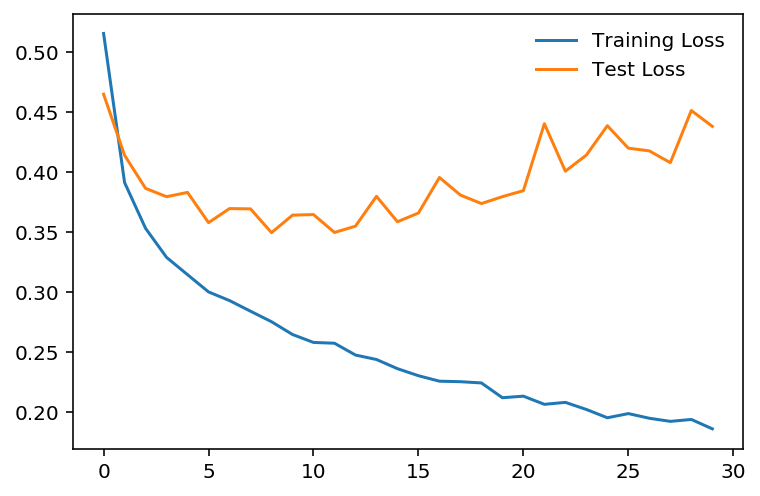

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(frameon=False)

# Overfitting

The most common method to reduce overfitting is dropout, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data.

We need to turn off dropout during validation, testing and whenever we're using the network to make predictions.

**Exercise**

Add dropout to your model and train it on Fasion-MNIST again. Try to get a lower validation loss or higher accuracy.

In [12]:
import torch.nn.functional as F
from torch import nn, optim
# Define the model with dropout

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output, so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use model.eval(). This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with model.train(). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

In [13]:
# Train the model with dropout, and monitor
# the training process with the validation loss
# and accuracy
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3
steps = 0

train_losses, test_losses = [], []

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        val_accuracy = 0
        test_loss = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                logps = model(images)
                loss = criterion(logps, labels)
                test_loss += loss
                
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch {}/{}".format(epoch+1, epochs),
              "Training Loss.. {}".format(running_loss/len(trainloader)),
              "Testing Loss.. {}".format(test_loss/len(testloader)),
              "Validation Accuracy.. {}".format(val_accuracy/len(testloader)))

Epoch 1/3 Training Loss.. 0.6022544196451397 Testing Loss.. 0.4673821032047272 Validation Accuracy.. 0.8247412443161011
Epoch 2/3 Training Loss.. 0.43398870548396223 Testing Loss.. 0.4215576648712158 Validation Accuracy.. 0.8485270738601685
Epoch 3/3 Training Loss.. 0.396742420187637 Testing Loss.. 0.40832704305648804 Validation Accuracy.. 0.8547969460487366


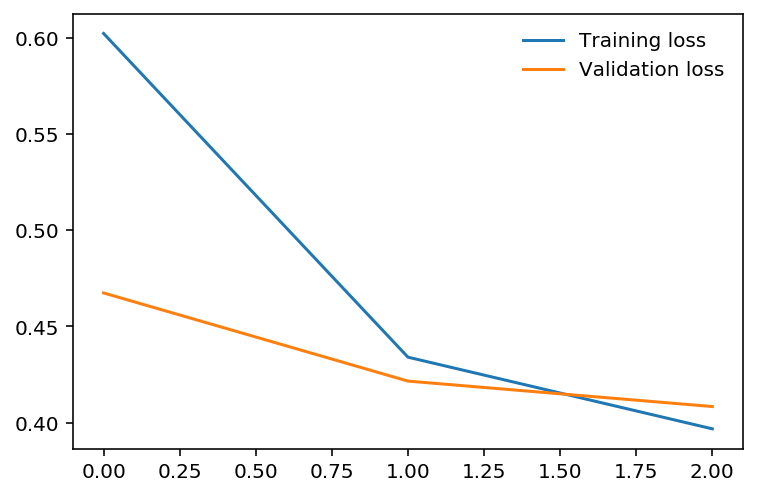

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Inference

We need to set the model in inference mode with *model.eval()*.

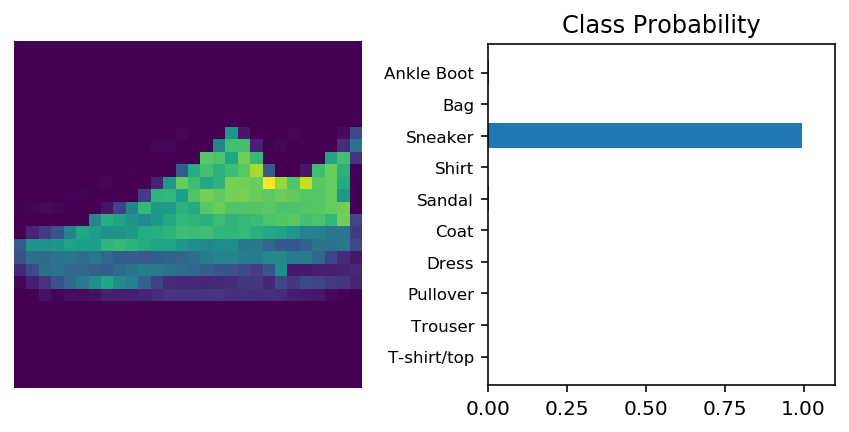

In [15]:
import helper

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities 
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), 
                     ps, 
                     version='Fashion')